## Detecting_Spam_Emails_Using_Tensorflow
Spam messages refer to unsolicited or unwanted messages/emails that are sent in bulk to users. In most messaging/emailing services, messages are detected as spam automatically so that these messages do not unnecessarily flood the users’ inboxes. These messages are usually promotional and peculiar in nature. Thus, it is possible for us to build ML/DL models that can detect Spam messages.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data = pd.read_csv("emails.csv")

In [3]:
# First five rows
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data.shape

(5728, 2)

In [5]:
# Information of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [6]:
# Check missing values
data.isna().sum()

text    0
spam    0
dtype: int64

## Exploratory Data Analysis

In [7]:
data['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

<AxesSubplot:xlabel='spam', ylabel='count'>

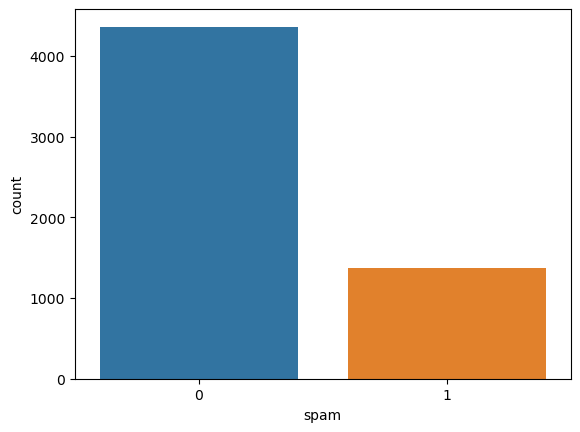

In [8]:
sns.countplot(data['spam'])

In [9]:
from nltk import word_tokenize

In [10]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

In [11]:
data['count'] = data['text'].apply(count_words)
data['count']

0       325
1        90
2        88
3        99
4        53
       ... 
5723    298
5724    245
5725    516
5726    277
5727    445
Name: count, Length: 5728, dtype: int64

In [12]:
data.groupby('spam')['count'].mean()

spam
0    346.835321
1    267.896199
Name: count, dtype: float64

## Text Prepreocessing

In [13]:
import string
from nltk.corpus import stopwords

In [14]:
data['text'] = data['text'].str.replace('Subject', '')
data.head()

,text,spam,count
0,: naturally irresistible your corporate identi...,1,325
1,: the stock trading gunslinger fanny is merri...,1,90
2,: unbelievable new homes made easy im wanting...,1,88
3,: 4 color printing special request additional...,1,99
4,": do not have money , get software cds from he...",1,53


In [15]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
data['text']= data['text'].apply(lambda x: remove_punctuations(x))
data.head()

,text,spam,count
0,naturally irresistible your corporate identit...,1,325
1,the stock trading gunslinger fanny is merril...,1,90
2,unbelievable new homes made easy im wanting ...,1,88
3,4 color printing special request additional ...,1,99
4,do not have money get software cds from here...,1,53


In [16]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
 data['text'] = data['text'].apply(lambda text: remove_stopwords(text))
data.head()

,text,spam,count
0,naturally irresistible corporate identity lt r...,1,325
1,stock trading gunslinger fanny merrill muzo co...,1,90
2,unbelievable new homes made easy im wanting sh...,1,88
3,4 color printing special request additional in...,1,99
4,money get software cds software compatibility ...,1,53


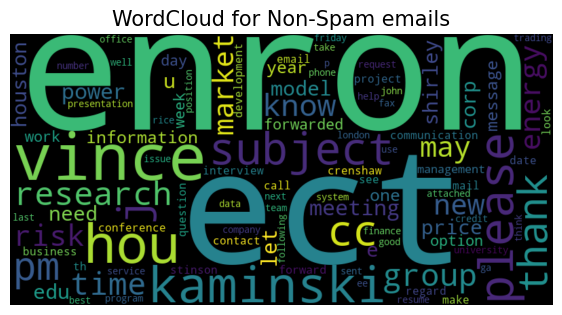

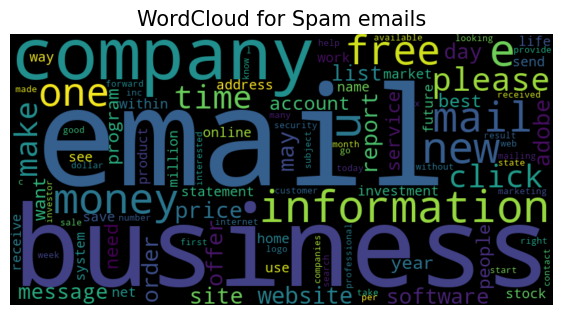

In [17]:
from wordcloud import WordCloud
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
 plot_word_cloud(data[data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(data[data['spam'] == 1], typ='Spam')

### Word2Vec Conversion

In [18]:
#train test split
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(data['text'],data['spam'],test_size = 0.2,random_state = 42)

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

In [20]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1078752   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,082,465
Trainable params: 1,082,465
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),metrics = ['accuracy'],
              optimizer = 'adam')

In [22]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32)

Epoch 1/20
144/144 [==============================] - 14s 77ms/step - loss: 0.3948 - accuracy: 0.8230 - val_loss: 0.1542 - val_accuracy: 0.9660
Epoch 2/20
144/144 [==============================] - 10s 71ms/step - loss: 0.0812 - accuracy: 0.9825 - val_loss: 0.1492 - val_accuracy: 0.9712
Epoch 3/20
144/144 [==============================] - 10s 67ms/step - loss: 0.0725 - accuracy: 0.9808 - val_loss: 0.1096 - val_accuracy: 0.9791
Epoch 4/20
144/144 [==============================] - 9s 61ms/step - loss: 0.0732 - accuracy: 0.9804 - val_loss: 0.1109 - val_accuracy: 0.9747
Epoch 5/20
144/144 [==============================] - 9s 60ms/step - loss: 0.0556 - accuracy: 0.9895 - val_loss: 0.0920 - val_accuracy: 0.9799
Epoch 6/20
144/144 [==============================] - 9s 62ms/step - loss: 0.0323 - accuracy: 0.9937 - val_loss: 0.0946 - val_accuracy: 0.9782
Epoch 7/20
144/144 [==============================] - 9s 61ms/step - loss: 0.0219 - accuracy: 0.9959 - val_loss: 0.0890 - val_accuracy: 0.9

In [23]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

36/36 [==============================] - 0s 13ms/step - loss: 0.1140 - accuracy: 0.9808
Test Loss : 0.11398464441299438
Test Accuracy : 0.9808027744293213


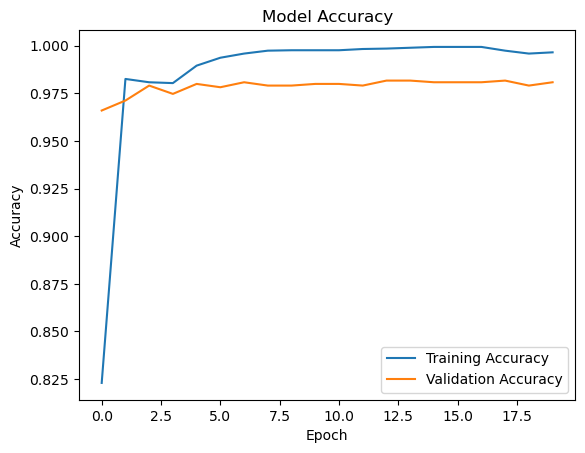

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()